In [1]:
import os
import numpy as np
from collections import OrderedDict


In [2]:
#you may install tflite by pip install tflite

In [3]:
from tflite import Model

In [4]:
data = open("./M-LSD_512_tiny_fp32.tflite", "rb").read()
tf_model = Model.GetRootAsModel(data, 0)
subgraph = tf_model.Subgraphs(0)
subgraph.Name()

b'main'

In [5]:
def get_shape(tensor):
    return [tensor.Shape(i) for i in range(tensor.ShapeLength())]



In [6]:
tensor_list = []
for i in range(3, subgraph.OperatorsLength()):
    op = subgraph.Operators(i)
    print(op.BuiltinOptionsType())
    if op.BuiltinOptionsType() not in [1, 2]: ##conv , depth conv
        continue
    one_layer_p = []
    for j in range(1, op.InputsLength()):
        tensor_index = op.Inputs(j)
    # use `graph.Tensors(index)` to get the tensor object.
        tensor = subgraph.Tensors(tensor_index)
        if tensor.Buffer() > 0 and (tensor.Type() == 0 or tensor.Type() == 1):
            s = get_shape(tensor)
            name = tensor.Name().decode('utf-8')
            print(name, s)
            layer_type = 'conv'
            if   'depthwise' in    name:
                layer_type = 'depthwise_conv'
            if len(s)==1:
                #bias
                one_layer_p.append({
                    'name': name,
                    'tensor': tensor,
                    'shape': s,
                    'type_maybe': layer_type + '_bias'
                })
            else:
                #weight
                one_layer_p.append({
                    'name': name,
                    'tensor': tensor,
                    'shape': s,
                    'type_maybe': layer_type + '_weight'
                })
    if len(one_layer_p) >0:
        tensor_list.append(one_layer_p)

1
WireFrameModel_with_alpha/Conv1_with_alpha/Conv2D [32, 3, 3, 4]
WireFrameModel_with_alpha/bn_Conv1/FusedBatchNormV3 [32]
2
WireFrameModel_with_alpha/expanded_conv_depthwise_BN/FusedBatchNormV3;WireFrameModel_with_alpha/expanded_conv_depthwise/depthwise;WireFrameModel_with_alpha/decoder_fpn/upblock_1/conv_bn__act_4/conv/Conv2D [1, 3, 3, 32]
WireFrameModel_with_alpha/expanded_conv_depthwise_BN/FusedBatchNormV3 [32]
1
WireFrameModel_with_alpha/expanded_conv_project/Conv2D [16, 1, 1, 32]
WireFrameModel_with_alpha/expanded_conv_project_BN/FusedBatchNormV3;WireFrameModel_with_alpha/Decoder/conv2d/Conv2D;WireFrameModel_with_alpha/expanded_conv_project/Conv2D [16]
1
WireFrameModel_with_alpha/block_1_expand/Conv2D [96, 1, 1, 16]
WireFrameModel_with_alpha/block_1_expand_BN/FusedBatchNormV3 [96]
22
2
WireFrameModel_with_alpha/block_1_depthwise_BN/FusedBatchNormV3;WireFrameModel_with_alpha/block_1_depthwise/depthwise [1, 3, 3, 96]
WireFrameModel_with_alpha/block_1_depthwise_BN/FusedBatchNormV3 [

In [7]:
import sys
sys.path.append('../')
from models.mbv2_mlsd_tiny import MobileV2_MLSD_Tiny
model = MobileV2_MLSD_Tiny()
model = model.eval()



In [8]:
import torch
import torch.nn as nn
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
        running_var = torch.ones_like(m.running_var)
        running_var = torch.sqrt(torch.ones_like(m.running_var) - m.eps)
        m.running_var.copy_(m.running_var)

In [9]:
state_dict = model.state_dict()
state_dict_selected = {}
for k,v in state_dict.items():
    print(k, v.shape)
    if len(v.shape) == 4:
        state_dict_selected[k] = v
    elif 'running_mean' in k:
        state_dict_selected[k] = v
    ## !! in large model you need to change it to block23
    elif 'block16.conv3.bias' in k: 
        state_dict_selected[k] = v

backbone.features.0.0.weight torch.Size([32, 4, 3, 3])
backbone.features.0.1.weight torch.Size([32])
backbone.features.0.1.bias torch.Size([32])
backbone.features.0.1.running_mean torch.Size([32])
backbone.features.0.1.running_var torch.Size([32])
backbone.features.0.1.num_batches_tracked torch.Size([])
backbone.features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
backbone.features.1.conv.0.1.weight torch.Size([32])
backbone.features.1.conv.0.1.bias torch.Size([32])
backbone.features.1.conv.0.1.running_mean torch.Size([32])
backbone.features.1.conv.0.1.running_var torch.Size([32])
backbone.features.1.conv.0.1.num_batches_tracked torch.Size([])
backbone.features.1.conv.1.weight torch.Size([16, 32, 1, 1])
backbone.features.1.conv.2.weight torch.Size([16])
backbone.features.1.conv.2.bias torch.Size([16])
backbone.features.1.conv.2.running_mean torch.Size([16])
backbone.features.1.conv.2.running_var torch.Size([16])
backbone.features.1.conv.2.num_batches_tracked torch.Size([])
backbone.fea

In [10]:
import numpy as np
tf_tensor_list = []
for i, t in enumerate(tensor_list):
    for p in t:
        tf_tensor_list.append(p)

for i, (k,v) in enumerate(state_dict_selected.items()):
    tf_tensor = tf_tensor_list[i]['tensor']
    buffer = tf_tensor.Buffer()
    shape = get_shape(tf_tensor)
    assert(tf_tensor.Type() == 0 or tf_tensor.Type() == 1)  # FLOAT32
    
    W = np.array(tf_model.Buffers(buffer).DataAsNumpy())
    if tensor.Type() == 0:
        W = W.view(dtype=np.float32)
    elif tensor.Type() == 1:
        W = W.view(dtype=np.float16)
    W = W.reshape(shape)
    if W.ndim == 4:
        if W.shape[0] == 1:
             W = W.transpose((3, 0, 1, 2))  # depthwise conv
        else:
             W = W.transpose((0, 3, 1, 2))  #  conv
    W_np = torch.from_numpy(W)
    if W.ndim ==1 and 'bias' not in k:
        #print('bias cvt to bn running mean')
        W_np = -W_np
    assert   v.shape == W_np.shape
    print(k, v.shape, W_np.shape)
    state_dict_selected[k] = W_np

backbone.features.0.0.weight torch.Size([32, 4, 3, 3]) torch.Size([32, 4, 3, 3])
backbone.features.0.1.running_mean torch.Size([32]) torch.Size([32])
backbone.features.1.conv.0.0.weight torch.Size([32, 1, 3, 3]) torch.Size([32, 1, 3, 3])
backbone.features.1.conv.0.1.running_mean torch.Size([32]) torch.Size([32])
backbone.features.1.conv.1.weight torch.Size([16, 32, 1, 1]) torch.Size([16, 32, 1, 1])
backbone.features.1.conv.2.running_mean torch.Size([16]) torch.Size([16])
backbone.features.2.conv.0.0.weight torch.Size([96, 16, 1, 1]) torch.Size([96, 16, 1, 1])
backbone.features.2.conv.0.1.running_mean torch.Size([96]) torch.Size([96])
backbone.features.2.conv.1.0.weight torch.Size([96, 1, 3, 3]) torch.Size([96, 1, 3, 3])
backbone.features.2.conv.1.1.running_mean torch.Size([96]) torch.Size([96])
backbone.features.2.conv.2.weight torch.Size([24, 96, 1, 1]) torch.Size([24, 96, 1, 1])
backbone.features.2.conv.3.running_mean torch.Size([24]) torch.Size([24])
backbone.features.3.conv.0.0.wei

In [11]:
state_dict.update(state_dict_selected)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
torch.save(state_dict, 'from_tf.pth')

In [14]:
import cv2
img = cv2.imread('../data/frame_1.jpg')
img = cv2.resize(img, (512, 512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

In [15]:
import torch
img = ( img / 127.5) - 1.0
img = img.transpose(2,0,1)
inputs = torch.from_numpy(img).unsqueeze(0)
y = model(inputs.float())

center_map = y[0][0]
center_map = torch.sigmoid(center_map)
center_map_np = center_map.detach().numpy()


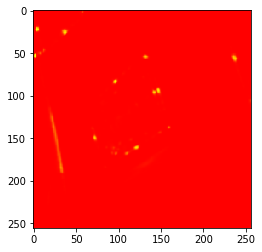

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(center_map_np , cmap = 'autumn' , interpolation = 'nearest' )
plt.show()